# PosRecoCNN Training

Position reconstruction CNN training pipeline for SBND detector.
Uses ResNet-18 architecture to predict particle positions from PMT data.

## 1. Setup and Configuration

In [26]:
# Suppress TensorFlow warnings and info messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Only if you want to specify GPU

# Essential imports only
import sys
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# TensorFlow with GPU memory growth
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#  Configure GPU memory growth for JupyterHub
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
   tf.config.experimental.set_memory_growth(gpus[0], True)
   print(">> GPU configured with memory growth for JupyterHub")
   print(f"   * Available GPU: {gpus[0]}")
  except RuntimeError as e:
   print(f"! GPU configuration warning: {e}")
else:
  print("! No GPU found")

# Auto-detect training directory based on project structure
def find_training_directory():
  """Find the training directory automatically based on project structure."""

  # Method 1: Check if we're already in the training directory
  if os.path.exists('config.py') and os.path.exists('utils.py'):
   return os.getcwd()

  # Method 2: Look for sbndcode structure from common paths
  possible_bases = [
   # Standard LArSoft development paths
   "/exp/sbnd/app/users/{}/larsoft_*/srcs/sbndcode",
   "/exp/sbnd/app/users/{}/*/srcs/sbndcode",
   # Alternative paths
   "/home/{}/sbndcode",
   "/home/{}/larsoft_*/srcs/sbndcode",
   # Current directory relatives
   "./sbndcode",
   "../sbndcode",
   "../../sbndcode",
  ]

  # Get current user
  import getpass
  username = getpass.getuser()

  # Expand paths with username and wildcards
  import glob
  expanded_paths = []
  for base in possible_bases:
   if '{}' in base:
    base = base.format(username)
   if '*' in base:
    expanded_paths.extend(glob.glob(base))
   else:
    expanded_paths.append(base)

  # Check each potential sbndcode directory
  for sbndcode_path in expanded_paths:
   training_path = os.path.join(sbndcode_path, "sbndcode", "PosRecoCVN", "training")
   if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
    return training_path

  # Method 3: Search upwards from current directory
  current = os.getcwd()
  for _ in range(5):  # Don't go too far up
   training_path = os.path.join(current, "sbndcode", "PosRecoCVN", "training")
   if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
    return training_path
   parent = os.path.dirname(current)
   if parent == current:  # reached root
    break
   current = parent

  return None

# Find and set training directory
print(">> Auto-detecting training directory...")
training_dir = find_training_directory()

if training_dir:
  print(f">> Found training directory: {training_dir}")
  if os.getcwd() != training_dir:
   print(f"   * Changing directory from {os.getcwd()} to {training_dir}")
   os.chdir(training_dir)
else:
  print("! Could not find training directory automatically")
  print("* Manual setup options:")
  print("  1. Navigate to your training directory:")
  print("     os.chdir('/path/to/your/sbndcode/sbndcode/PosRecoCVN/training')")
  print("  2. Or copy the required files:")
  print("     !cp /path/to/your/training/config.py .")
  print("     !cp /path/to/your/training/utils.py .")
  print("  3. Or add your training directory to Python path:")
  print("     sys.path.append('/path/to/your/training/directory')")

# Add current directory to Python path
if os.getcwd() not in sys.path:
  sys.path.append(os.getcwd())

# Debug info
print(f"\n* Current working directory: {os.getcwd()}")
print(f"* config.py exists: {os.path.exists('config.py')}")
print(f"* utils.py exists: {os.path.exists('utils.py')}")

# Try to import local modules
config_imported = False
utils_imported = False

try:
  from config import *
  config_imported = True
  print(">> config module imported successfully")
except ImportError as e:
  print(f"! config import error: {e}")

try:
  from utils import *
  utils_imported = True
  print(">> utils module imported successfully")
except ImportError as e:
  print(f"! utils import error: {e}")

if not (config_imported and utils_imported):
  print("\n* If auto-detection failed, try one of these solutions:")
  print("  1. Manual directory change:")
  print("     os.chdir('/exp/sbnd/app/users/YOUR_USERNAME/larsoft_*/srcs/sbndcode/sbndcode/PosRecoCVN/training')")
  print("  2. Add to Python path:")
  print("     sys.path.append('/path/to/your/training/directory')")
  print("  3. Copy files to current directory")
  print("\n   Then restart this cell.")

# Only run these if modules were imported successfully
if config_imported and utils_imported:
  print(" ============================================")
  print("   PosRecoCNN Training Pipeline - GPU Mode")
  print(" ============================================")
  print_config_summary()
  validate_paths()
else:
  print("! Skipping configuration check until modules are properly imported")

2025-09-19 13:45:18.909031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-19 13:45:18.909158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-19 13:45:18.911445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


>> GPU configured with memory growth for JupyterHub
   * Available GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
>> Auto-detecting training directory...
>> Found training directory: /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
   * Changing directory from /home/svidales to /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training

* Current working directory: /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
* config.py exists: True
* utils.py exists: True
>> config module imported successfully
>> utils module imported successfully
   PosRecoCNN Training Pipeline - GPU Mode
>> Configuration Summary
PMT Maps Directory: /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/pmt_maps
Model Export Path: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models
Training Data: mc_MCP2025B_02_prodgenie_corsika_proton_rockbox_sbnd

## 2. Data Loading

In [27]:
# Load training data
print(">> Loading training data...")
import time
start_time = time.time()

file = uproot.open(DATA_CONFIG['training_file'])
optree = file['opanatree']['OpAnaTree']

if LOADING_CONFIG['load_all']:
  print(f"   * Loading all events: {optree.num_entries:,}")
  arrays = []
  for i, key in enumerate(DATA_CONFIG['keys_to_load']):
   print(f"     - Loading {key}... ({i+1}/{len(DATA_CONFIG['keys_to_load'])}) [{100*(i+1)/len(DATA_CONFIG['keys_to_load']):.1f}%]")
   array = optree[key].array()
   arrays.append(array)
else:
  n_total = optree.num_entries
  n_load = int(n_total * LOADING_CONFIG['fraction'])
  start = LOADING_CONFIG['start_event']
  end = start + n_load
  print(f"   * Loading events {start}-{end} ({n_load:,}/{n_total:,})")
  arrays = []
  for i, key in enumerate(DATA_CONFIG['keys_to_load']):
   print(f"     - Loading {key}... ({i+1}/{len(DATA_CONFIG['keys_to_load'])}) [{100*(i+1)/len(DATA_CONFIG['keys_to_load']):.1f}%]")
   array = optree[key].array(entry_start=start, entry_stop=end)
   arrays.append(array)

loading_time = time.time() - start_time

# Unpack arrays
f_ophit_PE, f_ophit_ch, f_ophit_t, nuvT, dEpromx, dEpromy, dEpromz, dEtpc, nuvZ = arrays

# Display loading statistics
print(">> Data loaded successfully")
print(f"   * Loading time: {loading_time:.2f} seconds")
print(f"   * Loaded {len(arrays)} arrays:")
for i, key in enumerate(DATA_CONFIG['keys_to_load']):
  array = arrays[i]
  array_size_mb = array.nbytes / (1024*1024)
  print(f"     - {key}: {len(array):,} events, {array_size_mb:.1f} MB")

total_size_mb = sum(array.nbytes for array in arrays) / (1024*1024)
print(f"   * Total data size: {total_size_mb:.1f} MB")
print(f"   * Loading speed: {total_size_mb/loading_time:.1f} MB/s")

>> Loading training data...
   * Loading all events: 497,317
     - Loading flash_ophit_pe... (1/9) [11.1%]
     - Loading flash_ophit_ch... (2/9) [22.2%]
     - Loading flash_ophit_time... (3/9) [33.3%]
     - Loading nuvT... (4/9) [44.4%]
     - Loading dEpromx... (5/9) [55.6%]
     - Loading dEpromy... (6/9) [66.7%]
     - Loading dEpromz... (7/9) [77.8%]
     - Loading dEtpc... (8/9) [88.9%]
     - Loading nuvZ... (9/9) [100.0%]
>> Data loaded successfully
   * Loading time: 1396.66 seconds
   * Loaded 9 arrays:
     - flash_ophit_pe: 497,317 events, 9349.0 MB
     - flash_ophit_ch: 497,317 events, 4681.6 MB
     - flash_ophit_time: 497,317 events, 9349.0 MB
     - nuvT: 497,317 events, 10.6 MB
     - dEpromx: 497,317 events, 11.4 MB
     - dEpromy: 497,317 events, 11.4 MB
     - dEpromz: 497,317 events, 11.4 MB
     - dEtpc: 497,317 events, 11.4 MB
     - nuvZ: 497,317 events, 10.6 MB
   * Total data size: 23446.5 MB
   * Loading speed: 16.8 MB/s


In [47]:
print(dEpromx[12])
print(nuvZ[12])
print(f_ophit_t[0])

[-188, -999]
[423, 851]
[[4.55, 4.07, 3.75, 1.95, 1.72, ..., 0.638, 0.638, 0.638, 0.64, 0.642], ...]


## 3. Channel Dictionary and Event Filtering

In [3]:
# Create channel dictionary
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
Type = PDSMap['OpDetType'].array()
channel_dict = {id_val: int(type_val) for id_val, type_val in zip(ID[0], Type[0])}
print(f">> Channel dictionary created: {len(channel_dict)} channels")

# Process events with centralized configuration
print("\n>> Processing events...")
results = process_events(
  nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t,
  dEpromx, dEpromy, dEpromz, dEtpc, nuvZ,
  channel_dict, FILTER_CONFIG, verbose=True
)

# Unpack results
(nuvT_final, f_ophit_PE_final, f_ophit_ch_final, f_ophit_t_final,
 dEpromx_final, dEpromy_final, dEpromz_final, dEtpc_final, nuvZ_final, stats) = results

>> Channel dictionary created: 312 channels

>> Processing events...
>> Starting optimized event processing...
Initial events: 497,317
Processing flashes...
Applying data validity cuts...
Applying energy cuts...
Applying position cuts...
>> Processing completed in 7.42 seconds

Initial events: 497,317


,Cut,Removed,Remaining,Cumulative_Eff
0,Single neutrino,287236,210081,0.422
1,Has flashes,3316,206765,0.416
2,Valid data (≠ -999 in dEprom),323,206442,0.415
3,Energy cut,10370,196072,0.394
4,Position cut,847,195225,0.393


Final efficiency: 0.393 (195,225/497,317)

* Final dataset ranges:
  dEpromx: [-200.0, 200.0]
  dEpromy: [-199.8, 199.8]
  dEpromz: [4.6, 500.0]
  dEtpc: [50.0, 7571.2]


## 4. PE Matrix and Image Creation

In [4]:
# Create PE matrix
print(">> Creating PE matrix...")
pe_matrix = create_pe_matrix(f_ophit_PE_final, f_ophit_ch_final, IMAGE_CONFIG['max_channels'])

# Load PMT maps with relative paths
print("\n>> Loading PMT maps...")
uncoated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['uncoated'], delimiter=",", dtype=int)
coated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['coated'], delimiter=",", dtype=int)
print(f"   * Uncoated map shape: {uncoated_map.shape}")
print(f"   * Coated map shape: {coated_map.shape}")

# Create images and store normalization factors
print("\n>> Creating PE images...")
images, normalization_factors = create_pe_images(
  pe_matrix, uncoated_map, coated_map, 
  method=IMAGE_CONFIG['selection_method']
)

print(f">> Images created: {images.shape}")
print(f"   * Normalization factors: {normalization_factors}")

>> Creating PE matrix...
Creating PE matrix for 195,225 events x 312 channels
  Processing event 0/195,225 (0.0%)


  Processing event 10,000/195,225 (5.1%)
  Processing event 20,000/195,225 (10.2%)
  Processing event 30,000/195,225 (15.4%)
  Processing event 40,000/195,225 (20.5%)
  Processing event 50,000/195,225 (25.6%)
  Processing event 60,000/195,225 (30.7%)
  Processing event 70,000/195,225 (35.9%)
  Processing event 80,000/195,225 (41.0%)
  Processing event 90,000/195,225 (46.1%)
  Processing event 100,000/195,225 (51.2%)
  Processing event 110,000/195,225 (56.3%)
  Processing event 120,000/195,225 (61.5%)
  Processing event 130,000/195,225 (66.6%)
  Processing event 140,000/195,225 (71.7%)
  Processing event 150,000/195,225 (76.8%)
  Processing event 160,000/195,225 (82.0%)
  Processing event 170,000/195,225 (87.1%)
  Processing event 180,000/195,225 (92.2%)
  Processing event 190,000/195,225 (97.3%)
>> Completed in 168.15 seconds
Matrix shape: (195225, 312)
Non-zero elements: 26,898,643
Total PE: 3400410624.0

>> Loading PMT maps...
   * Uncoated map shape: (118, 70)
   * Coated map shape:

## 5. Target Variable Preparation

In [5]:
# Prepare coordinates (use absolute x)
print(">> Preparing target variables...")
x_abs = np.abs(np.array(dEpromx_final).flatten())
y = np.array(dEpromy_final).flatten()
z = np.array(dEpromz_final).flatten()

coordinates = np.column_stack((x_abs, y, z))
print(f"   * Coordinate ranges before scaling:")
print(f"     - X (abs): [{np.min(x_abs):.1f}, {np.max(x_abs):.1f}]")
print(f"     - Y: [{np.min(y):.1f}, {np.max(y):.1f}]")
print(f"     - Z: [{np.min(z):.1f}, {np.max(z):.1f}]")

# Scale coordinates using config
y_scaled = scale_coordinates(coordinates, COORD_CONFIG['ranges'])
print(f"\n   * Scaled coordinate ranges:")
print(f"     - X: [{np.min(y_scaled[:, 0]):.3f}, {np.max(y_scaled[:, 0]):.3f}]")
print(f"     - Y: [{np.min(y_scaled[:, 1]):.3f}, {np.max(y_scaled[:, 1]):.3f}]")
print(f"     - Z: [{np.min(y_scaled[:, 2]):.3f}, {np.max(y_scaled[:, 2]):.3f}]")

>> Preparing target variables...
   * Coordinate ranges before scaling:
     - X (abs): [0.6, 200.0]
     - Y: [-199.8, 199.8]
     - Z: [4.6, 500.0]

   * Scaled coordinate ranges:
     - X: [0.003, 1.000]
     - Y: [-0.999, 0.999]
     - Z: [0.009, 1.000]


## 6. Train/Validation Split

In [6]:
# Calculate split sizes (no test split - handled separately in inference)
n_total = len(y_scaled)
n_train = int(n_total * TRAINING_CONFIG['train_fraction'])
n_val = n_total - n_train  # Use remaining for validation

print(f">> Dataset splits:")
print(f"   * Training: {n_train:,} ({100*n_train/n_total:.1f}%)")
print(f"   * Validation: {n_val:,} ({100*n_val/n_total:.1f}%)")
print(f"   * Test: Handled separately in PosRecoCNN_Inference notebook")

# Create splits
x_train = images[:n_train]
x_val = images[n_train:]

y_train = y_scaled[:n_train]
y_val = y_scaled[n_train:]

print(f"\n>> Data splits created:")
print(f"   * x_train: {x_train.shape}")
print(f"   * x_val: {x_val.shape}")

>> Dataset splits:
   * Training: 165,941 (85.0%)
   * Validation: 29,284 (15.0%)
   * Test: Handled separately in PosRecoCNN_Inference notebook

>> Data splits created:
   * x_train: (165941, 59, 70, 2)
   * x_val: (29284, 59, 70, 2)


## 7. Model Definition (ResNet-18 Architecture)

In [12]:
# Clear everything and restart model training from scratch
import gc
print(">> Clearing GPU memory and resetting model...")

# Clear Keras session completely
tf.keras.backend.clear_session()

# Force garbage collection
gc.collect()

# Delete existing model if it exists
try:
  del Model
  print("   * Deleted existing model")
except:
  print("   * No existing model to delete")

# Clear any existing variables that might interfere
try:
  del history
  print("   * Deleted training history")
except:
  pass

print(">> Memory and model cleared - ready for fresh training")

>> Clearing GPU memory and resetting model...
   * No existing model to delete
>> Memory and model cleared - ready for fresh training


*ResNet CNN*

In [ ]:
# Define ResNet-18 architecture (keeping original as it works well)
def create_resnet18_model(input_shape, dropout_rate=0.4):
  """Create ResNet-18 model for position regression."""
  
  # Input layer
  input_layer = layers.Input(shape=input_shape)

  # Initial convolution layer
  x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(input_layer)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

  # Define the basic residual block
  def basic_block(input_tensor, filters, stride=1, downsample=False):
   shortcut = input_tensor

   x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(input_tensor)
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)

   x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
   x = layers.BatchNormalization()(x)

   if downsample:
    shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

   x = layers.Add()([x, shortcut])
   x = layers.ReLU()(x)
   return x

  # ResNet-18 stages
  x = basic_block(x, 64)
  x = basic_block(x, 64)

  x = basic_block(x, 128, stride=2, downsample=True)
  x = basic_block(x, 128)

  x = basic_block(x, 256, stride=1, downsample=True)
  x = basic_block(x, 256)

  x = basic_block(x, 512, stride=1, downsample=True)
  x = basic_block(x, 512)

  # Global Average Pooling and output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(dropout_rate)(x)
  output = layers.Dense(3)(x)  # 3 coordinates: x, y, z

  return models.Model(inputs=input_layer, outputs=output)

# Create fresh model from scratch
print(">> Creating fresh ResNet-18 model...")
input_shape = x_train.shape[1:]
Model = create_resnet18_model(input_shape, TRAINING_CONFIG['dropout_rate'])

print(f">> Fresh model created with input shape: {input_shape}")
print(f"   * Total parameters: {Model.count_params():,}")
print(">> Model ready for training from scratch")

*4 conv + 4 dense*

In [13]:
# Define CNN architecture using function-based approach 
def create_cnn_model(input_shape, dropout_rate=0.3):
    """Create CNN model for position regression."""
    
    # Input layer
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    x = layers.Conv2D(32, (3,3), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    
    # Second convolutional block
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    
    # Third convolutional block
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    
    # Flatten the output and pass through dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Output layer
    output = layers.Dense(3, activation='linear')(x)
    
    return models.Model(inputs=input_layer, outputs=output)

# Create fresh model from scratch
print(">> Creating fresh CNN model...")
input_shape = x_train.shape[1:]
Model = create_cnn_model(input_shape, TRAINING_CONFIG['dropout_rate'])

print(f">> Fresh model created with input shape: {input_shape}")
print(f"   * Total parameters: {Model.count_params():,}")
print(">> Model ready for training from scratch")


>> Creating fresh CNN model...
>> Fresh model created with input shape: (59, 70, 2)
   * Total parameters: 6,323,363
>> Model ready for training from scratch


## 8. Training

In [14]:
# Display current training configuration
print(">> ==========================================")
print("   Current Training Configuration")
print("   ==========================================")
print(f"   * Epochs: {TRAINING_CONFIG['epochs']}")
print(f"   * Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"   * Original patience: {TRAINING_CONFIG['patience']}")
print(f"   * Reduce LR patience: {TRAINING_CONFIG['reduce_lr_patience']}")
print(f"   * Reduce LR factor: {TRAINING_CONFIG['reduce_lr_factor']}")
print(f"   * Min LR: {TRAINING_CONFIG['min_lr']}")
print(f"   * Dropout rate: {TRAINING_CONFIG['dropout_rate']}")
print(f"   * Optimizer: {TRAINING_CONFIG['optimizer']}")
print(f"   * Loss: {TRAINING_CONFIG['loss']}")
print(f"   * Metrics: {TRAINING_CONFIG['metrics']}")

# Adjust training configuration for stability
print("\n>> Adjusting training parameters for stability...")
TRAINING_CONFIG['patience'] = 4  # Increase patience
TRAINING_CONFIG['batch_size'] = 64  # Increase batch size for stable BN
TRAINING_CONFIG['reduce_lr_patience'] = 3  # Reduce LR sooner
TRAINING_CONFIG['reduce_lr_factor'] = 0.5  # More aggressive LR reduction

print(f"   * Batch size changed to: {TRAINING_CONFIG['batch_size']}")
print(f"   * Early stopping patience: {TRAINING_CONFIG['patience']}")
print(f"   * Reduce LR patience: {TRAINING_CONFIG['reduce_lr_patience']}")
print(f"   * Reduce LR factor: {TRAINING_CONFIG['reduce_lr_factor']}")

# Create optimizer with lower initial learning rate
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)  # Lower LR
print(f"   * Using lower initial learning rate: 0.0005")

# Setup callbacks
print("\n>> Setting up training callbacks...")
callbacks = [
  ModelCheckpoint(
   MODEL_CONFIG['weights_file'],
   monitor='val_loss',
   verbose=1,  # Show when saving
   save_best_only=True,
   mode='min'
  ),
  EarlyStopping(
   monitor='val_loss',
   patience=TRAINING_CONFIG['patience'],
   restore_best_weights=True,
   verbose=1
  ),
  ReduceLROnPlateau(
   monitor='val_loss',
   factor=TRAINING_CONFIG['reduce_lr_factor'],
   patience=TRAINING_CONFIG['reduce_lr_patience'],
   min_lr=TRAINING_CONFIG['min_lr'],
   verbose=1
  )
]

# Recompile model with new optimizer
Model.compile(
  optimizer=optimizer,
  loss=TRAINING_CONFIG['loss'],
  metrics=TRAINING_CONFIG['metrics']
)

# Train model
print(">> Starting training with improved stability...")
history = Model.fit(
  x_train, y_train,
  epochs=TRAINING_CONFIG['epochs'],
  batch_size=TRAINING_CONFIG['batch_size'],
  callbacks=callbacks,
  validation_data=(x_val, y_val),
  verbose=1
)

print(">> Training completed")

>> ==========================================
   Current Training Configuration
   * Epochs: 80
   * Batch size: 64
   * Original patience: 4
   * Reduce LR patience: 3
   * Reduce LR factor: 0.5
   * Min LR: 1e-06
   * Dropout rate: 0.2
   * Optimizer: adam
   * Loss: mean_squared_error
   * Metrics: ['mse']

>> Adjusting training parameters for stability...
   * Batch size changed to: 64
   * Early stopping patience: 4
   * Reduce LR patience: 3
   * Reduce LR factor: 0.5
   * Using lower initial learning rate: 0.0005

>> Setting up training callbacks...
>> Starting training with improved stability...
Epoch 1/80
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0966 - mse: 0.0966
Epoch 1: val_loss improved from None to 0.09812, saving model to /tmp/weights_nuvT.hdf5.keras
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0981 - val_mse: 0.0981 - learning_rate: 5.0000e-04
Epoch 2/80
2592/2593 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - ms

## 9. Training History Visualization

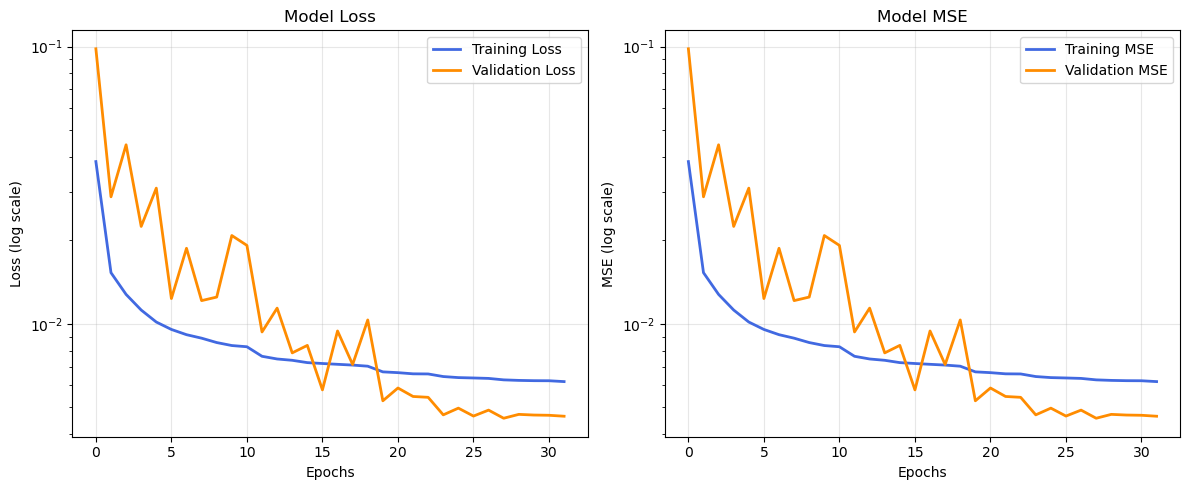

>> Final Training Loss: 0.006195
>> Final Validation Loss: 0.004647


In [15]:
# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='royalblue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# MSE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Training MSE', color='royalblue', linewidth=2)
plt.plot(history.history['val_mse'], label='Validation MSE', color='darkorange', linewidth=2)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('MSE (log scale)')
plt.title('Model MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f">> Final Training Loss: {final_train_loss:.6f}")
print(f">> Final Validation Loss: {final_val_loss:.6f}")

## 10. Model Export

In [16]:
# Export trained model for inference
import json
import gc

print(">> Exporting trained model for inference...")

# Create export directory
export_path = get_model_export_path(len(y_train))
os.makedirs(export_path, exist_ok=True)

# Export the model in SavedModel format for TensorFlow Serving
model_save_path = os.path.join(export_path, 'saved_model')
Model.export(model_save_path)  # SavedModel format for TF Serving
print(f"   * Model exported in SavedModel format: {model_save_path}")

# Convert numpy types to native Python types for JSON serialization
def convert_numpy_types(obj):
  """Convert numpy types to native Python types for JSON serialization."""
  if isinstance(obj, np.ndarray):
   return obj.tolist()
  elif isinstance(obj, (np.float32, np.float64)):
   return float(obj)
  elif isinstance(obj, (np.int32, np.int64)):
   return int(obj)
  elif isinstance(obj, dict):
   return {key: convert_numpy_types(value) for key, value in obj.items()}
  elif isinstance(obj, list):
   return [convert_numpy_types(item) for item in obj]
  return obj

# Save normalization factors and coordinate ranges for inference
inference_config = {
  'normalization_factors': convert_numpy_types(normalization_factors),
  'coord_ranges': convert_numpy_types(COORD_CONFIG['ranges']),
  'image_config': {
   'max_channels': IMAGE_CONFIG['max_channels'],
   'selection_method': IMAGE_CONFIG['selection_method']
  },
  'model_info': {
   'epochs_trained': len(history.history['loss']),
   'final_val_loss': float(final_val_loss),  # Convert to native float
   'training_events': len(y_train),
   'validation_events': len(y_val)
  }
}

# Save configuration files
norm_file = os.path.join(export_path, 'normalization_factors.json')
shared_norm_file = '/exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/normalization_factors.json'

with open(norm_file, 'w') as f:
  json.dump(inference_config, f, indent=2)

# Also save to shared location for easy access
os.makedirs(os.path.dirname(shared_norm_file), exist_ok=True)
with open(shared_norm_file, 'w') as f:
  json.dump(inference_config, f, indent=2)

print(f">> Model exported successfully:")
print(f"   * SavedModel: {model_save_path}")
print(f"   * Config: {norm_file}")
print(f"   * Shared config: {shared_norm_file}")
print(f"   * Trained on {len(y_train):,} events")

>> Exporting trained model for inference...


INFO:tensorflow:Assets written to: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0904_trained_w_165k/saved_model/assets


INFO:tensorflow:Assets written to: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0904_trained_w_165k/saved_model/assets


Saved artifact at '/exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0904_trained_w_165k/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 59, 70, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140200111964400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111974256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111120352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111121936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111980064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111117888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111121760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111128096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140200111128272: TensorSpec(shape=(), dtype=tf.resource

## 11. Prediction

In [17]:
# Make predictions on validation set
print(">> Making predictions on validation set...")
y_pred_scaled = Model.predict(x_val)

# Convert back to original coordinates
y_pred_original = inverse_scale_coordinates(y_pred_scaled, COORD_CONFIG['ranges'])
y_val_original = inverse_scale_coordinates(y_val, COORD_CONFIG['ranges'])

print(f">> Predictions completed for {len(y_val):,} validation events")
print(f"   * Prediction ranges:")
print(f"     - X: [{np.min(y_pred_original[:, 0]):.1f}, {np.max(y_pred_original[:, 0]):.1f}]")
print(f"     - Y: [{np.min(y_pred_original[:, 1]):.1f}, {np.max(y_pred_original[:, 1]):.1f}]")
print(f"     - Z: [{np.min(y_pred_original[:, 2]):.1f}, {np.max(y_pred_original[:, 2]):.1f}]")

>> Making predictions on validation set...
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
>> Predictions completed for 29,284 validation events
   * Prediction ranges:
     - X: [6.5, 200.1]
     - Y: [-196.2, 196.0]
     - Z: [-0.4, 513.0]


## 12. Model Evaluation on Validation Set

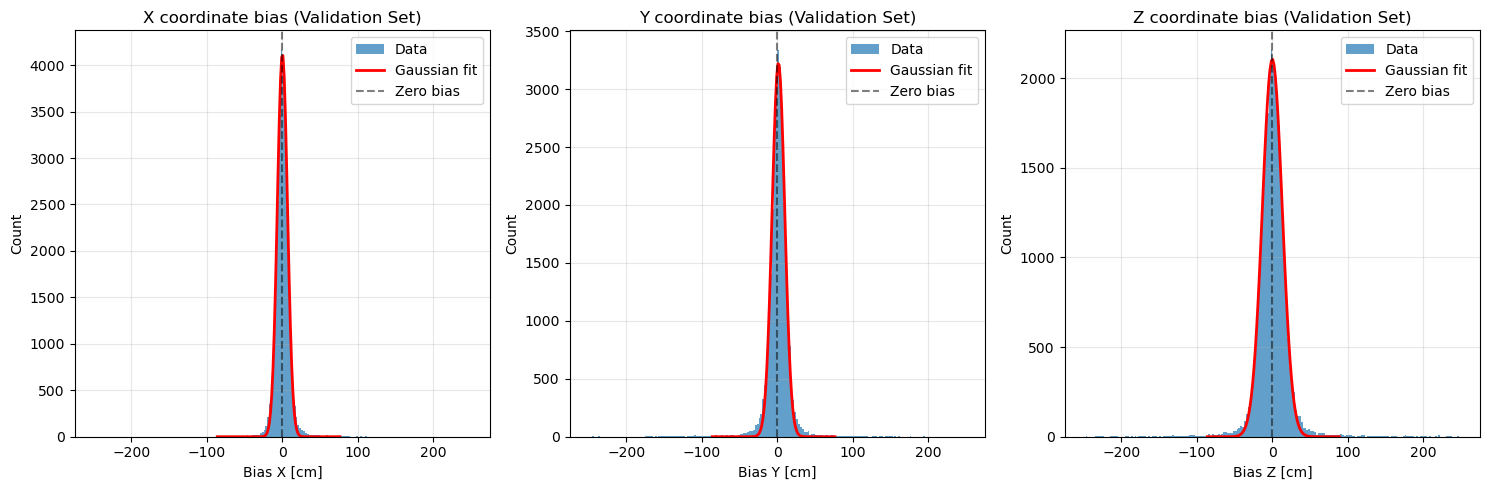


>> ======================================
   Validation Set Bias Analysis Results
   * X coordinate:
     - Mean bias: 0.02 cm
     - Resolution (σ): 6.71 cm

   * Y coordinate:
     - Mean bias: 1.39 cm
     - Resolution (σ): 8.35 cm

   * Z coordinate:
     - Mean bias: -0.10 cm
     - Resolution (σ): 13.16 cm



In [18]:
# Calculate differences (bias) and perform Gaussian fits
diff_coords = y_pred_original - y_val_original
coord_names = ['X', 'Y', 'Z']

# Gaussian fit function
def gaussian(x, a, x0, sigma):
  return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Bias analysis plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
bias_results = {}

for i, coord in enumerate(coord_names):
  diff = diff_coords[:, i]
  config = ANALYSIS_CONFIG['bias_analysis']
  
  # Create histogram
  counts, bins, _ = axs[i].hist(
   diff, 
   config['hist_bins'], 
   range=config['hist_ranges'][coord],
   alpha=0.7,
   label='Data'
  )
  
  # Prepare for Gaussian fit
  bin_centers = (bins[:-1] + bins[1:]) / 2
  fit_range = config['fit_ranges'][coord]
  
  # Fit Gaussian
  try:
   p0 = [np.max(counts), 0, 50]
   popt, _ = curve_fit(
    gaussian, 
    bin_centers[fit_range[0]:fit_range[1]], 
    counts[fit_range[0]:fit_range[1]], 
    p0=p0
   )
   
   # Plot fit
   x_fit = np.linspace(bin_centers[fit_range[0]], bin_centers[fit_range[1]], 100)
   y_fit = gaussian(x_fit, *popt)
   axs[i].plot(x_fit, y_fit, 'r-', linewidth=2, label='Gaussian fit')
   
   # Store results
   bias_results[coord] = {
    'mean': popt[1],
    'sigma': popt[2]
   }
   
  except Exception as e:
   print(f"! Warning: Could not fit Gaussian for {coord}: {e}")
   bias_results[coord] = {
    'mean': np.mean(diff),
    'sigma': np.std(diff)
   }
  
  axs[i].axvline(0, color='black', linestyle='--', alpha=0.5, label='Zero bias')
  axs[i].set_xlabel(f'Bias {coord} [cm]')
  axs[i].set_ylabel('Count')
  axs[i].set_title(f'{coord} coordinate bias (Validation Set)')
  axs[i].legend()
  axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print bias results
print("\n>> ======================================")
print("   Validation Set Bias Analysis Results")
print("   ======================================")
for coord in coord_names:
  mean = bias_results[coord]['mean']
  sigma = bias_results[coord]['sigma']
  print(f"   * {coord} coordinate:")
  print(f"     - Mean bias: {mean:.2f} cm")
  print(f"     - Resolution (σ): {sigma:.2f} cm")
  print()

## 13. Bias Analysis (Validation Set)

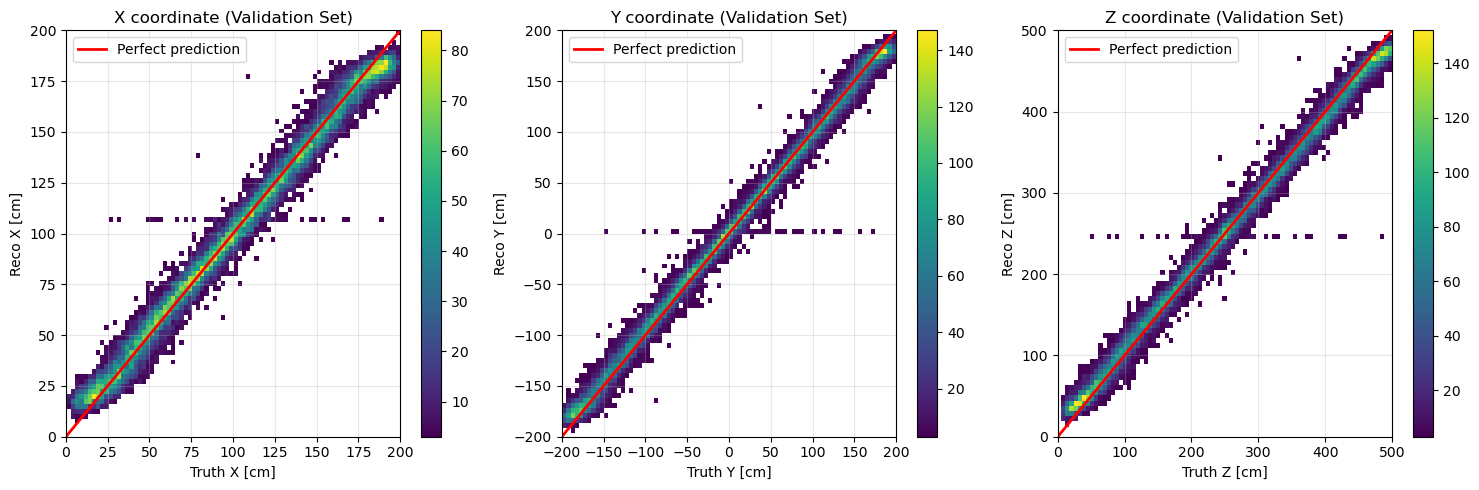

>> Performance Metrics:
   * RMSE per coordinate: X=10.69, Y=17.99, Z=26.25 cm
   * MAE per coordinate:  X=6.71, Y=9.69, Z=14.13 cm


In [19]:
# Reconstructed vs Truth comparison plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
coord_names = ['X', 'Y', 'Z']
coord_limits = [(0, 200), (-200, 200), (0, 500)]

for i, (coord, limits) in enumerate(zip(coord_names, coord_limits)):
  hist, xedges, yedges = np.histogram2d(
   y_val_original[:, i],
   y_pred_original[:, i],
   bins=ANALYSIS_CONFIG['reco_truth_comparison']['bins']
  )

  hist_masked = np.ma.masked_where(hist <= 2, hist)

  im = axs[i].pcolormesh(
   xedges, yedges, hist_masked.T,
   cmap=ANALYSIS_CONFIG['reco_truth_comparison']['cmap'],
   shading='auto'
  )

  # Agregar colorbar
  plt.colorbar(im, ax=axs[i])

  axs[i].plot(limits, limits, 'r-', linewidth=2, label='Perfect prediction')
  axs[i].set_xlim(limits)
  axs[i].set_ylim(limits)
  axs[i].set_xlabel(f'Truth {coord} [cm]')
  axs[i].set_ylabel(f'Reco {coord} [cm]')
  axs[i].set_title(f'{coord} coordinate (Validation Set)')
  axs[i].grid(True, alpha=0.3)
  axs[i].legend()

plt.tight_layout()
plt.show()

# Calculate and display performance metrics
mse_per_coord = np.mean((y_pred_original - y_val_original)**2, axis=0)
rmse_per_coord = np.sqrt(mse_per_coord)
mae_per_coord = np.mean(np.abs(y_pred_original - y_val_original), axis=0)
overall_rmse = np.sqrt(np.mean(rmse_per_coord**2))

print(f">> Performance Metrics:")
print(f"   * RMSE per coordinate: X={rmse_per_coord[0]:.2f}, Y={rmse_per_coord[1]:.2f}, Z={rmse_per_coord[2]:.2f} cm")
print(f"   * MAE per coordinate:  X={mae_per_coord[0]:.2f}, Y={mae_per_coord[1]:.2f}, Z={mae_per_coord[2]:.2f} cm")

## 14. Training Summary and Next Steps

In [20]:
print(">> ================================================")
print("   Training Pipeline Completed Successfully!")
print("   ================================================")
print(f"   * Dataset: {len(y_train):,} training events")
print(f"   * Validation: {len(y_val):,} validation events")
print(f"   * Model: ResNet-18 architecture")
print(f"   * Model saved to: {export_path}")
print(f"   * Final validation loss: {final_val_loss:.6f}")
print(f"   * Validation RMSE: {overall_rmse:.2f} cm")

print("\n>> Validation Performance Summary:")
for coord in coord_names:
  mean = bias_results[coord]['mean']
  sigma = bias_results[coord]['sigma']
  print(f"   * {coord}: Bias = {mean:.2f} cm, Resolution = {sigma:.2f} cm")

print("\n>> For test set evaluation and inference:")
print("   * 1. Use PosRecoCNN_Inference notebook")
print("   * 2. Load independent test data")  
print("   * 3. Apply same preprocessing pipeline")
print("   * 4. Compare test vs validation performance")

print(f"\n>> Files created:")
print(f"   * Model: {export_path}")
print(f"   * Normalization factors: {norm_file}")
print(f"   * Best weights: {MODEL_CONFIG['weights_file']}")

print(f"\n>> Next steps:")
print(f"   * 1. Run PosRecoCNN_Inference notebook for unbiased test evaluation")
print(f"   * 2. Compare test vs validation metrics")
print(f"   * 3. Deploy model for production inference")

# Clean up memory
del x_train, x_val, y_train, y_val, images, pe_matrix
gc.collect()
print(f"\n>> Memory cleaned up")

>> ================================================
   Training Pipeline Completed Successfully!
   * Dataset: 165,941 training events
   * Validation: 29,284 validation events
   * Model: ResNet-18 architecture
   * Model saved to: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0904_trained_w_165k
   * Final validation loss: 0.004647
   * Validation RMSE: 19.38 cm

>> Validation Performance Summary:
   * X: Bias = 0.02 cm, Resolution = 6.71 cm
   * Y: Bias = 1.39 cm, Resolution = 8.35 cm
   * Z: Bias = -0.10 cm, Resolution = 13.16 cm

>> For test set evaluation and inference:
   * 1. Use PosRecoCNN_Inference notebook
   * 2. Load independent test data
   * 3. Apply same preprocessing pipeline
   * 4. Compare test vs validation performance

>> Files created:
   * Model: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0904_trained_w_165k
   * Normalization factors: /exp/sbnd/data/users/svidales/AI_nuvT_project_